## Isolation Test 2 - After Ceiling Plate had been installed

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from numpy import nan
from pathlib import Path
from obspy import UTCDateTime, Stream

from andbro__get_timeaxis import __get_timeaxis
from andbro__load_FURT_stream import __load_furt_stream
from andbro__load_WROMY_stream import __load_wromy_stream

### Configurations

In [46]:
config = {}

config['channel'] = None

config['tbeg'] = UTCDateTime("2023-03-26 23:00")
config['tend'] = UTCDateTime("2023-03-30 00:00")

config['path_to_sds'] = f'/import/freenas-ffb-01-data/romy_archive/'

config['resample'] = 20

config['colors'] = {  'WS1':'darkgreen', 
                      'WS4':'purple', 
                      'WS5':'darkred',
                      'WS6':'darkblue',
                      'WS7':'darkorange',
                      'WS8':'darkcyan',
                      'WS9':'cyan',
                     }

### Methods

In [47]:
def __indicate_gaps_with_nan(df, config):
    
    differences = np.diff(df.totalSeconds, n=1)
    
    
    ## ______________
    
    sample_time_errors = [j for j in differences if j != config['resample']]

    if len(sample_time_errors) != 0:
        print(f"  -> ERROR: Found {len(sample_time_errors)} errors for the sampling time!\n")
    
    
    ## ______________
    
    gaps = [list(differences).index(k) for k in differences if k > 2*config['resample']] or []
    if gaps and gaps[0] in [0, 0.0]:
        gaps.pop(0)    
    del differences
    
    for x in gaps:
        fill_row = [i+config['resample'] if n not in [3,4,5] else np.nan for n, i in enumerate(df.iloc[x,:])]
        fill_row[0] = int(df.iloc[x,0])
        fill_row[1] = int(df.iloc[x,1])
        fill_row[2] = int(df.iloc[x,2])
        df.loc[x+0.5] = fill_row

    
    df = df.sort_index().reset_index(drop=True).convert_dtypes()

    print(f"  -> Marked {len(gaps)} gaps with NaN values!\n")
    
    return df

In [48]:
def __processing(data, config):
    
    filter_length = 10*config['resample']
    
    data.iloc[:,3:6] = data.iloc[:,3:6].rolling(filter_length).mean() 
    __reply(f"Filter: rooling mean {filter_length}!")
    
    data = data[data.index % config['resample'] == 0]
    __reply(f"Resampling: keep every {config['resample']}nth sample!")
    
    return data

### Load WROMY Data

In [49]:
furt = __load_furt_stream(config)

  0%|          | 0/5 [00:00<?, ?it/s]

Specified end: 2023-03-30T00:00:00.000000Z 
Trace end:     2023-03-30T00:00:00.000000Z


/home/brotzer/anaconda3/lib/python3.7/site-packages/andbro__load_FURT_stream.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['datetime'] = to_datetime(df['datetime'], format="%d%m%y %H%M%S", errors="coerce")


### Load WROMY Data

In [50]:
def __load_wromy_stream(path_to_sds, seed_id, tbeg, tend):
    
    '''
    
    reads WROMY data from tbeg to tend
    
    >>> __load_wromy_stream(path_to_sds, seed_id, tbeg, tend)
    
    '''

    from os.path import exists
    from pandas import date_range, read_csv, concat, DataFrame
    from tqdm.notebook import tqdm_notebook
    from obspy import Stream, UTCDateTime
    from numpy import nan, inf
    
    def __add_trace(seed_id, ch, tbeg, dat):

        from obspy import Trace, UTCDateTime
        from numpy import array
        from numpy.ma import masked_invalid

        net, sta, loc, cha = seed_id.split(".")

        tr = Trace()
        tr.stats.network = net
        tr.stats.station = 'WROMY'
        tr.stats.location = cha
        tr.stats.channel = str(ch)
        tr.stats.sampling_rate = 1.0
        tr.stats.starttime = UTCDateTime(tbeg)
        tr.data = masked_invalid(array(dat))

        return tr
    
    
    t1 = tbeg
    t2 = tend + 86410
    
    net, sta, loc, cha = seed_id.split(".")
    
    df = DataFrame()
    
    for n, date in enumerate(tqdm_notebook(date_range(t1.date, t2.date))):    
        doy = str(date.timetuple().tm_yday).rjust(3,"0")
        
#        path = f"/import/freenas-ffb-01-data/romy_archive/{date.year}/{net}/{sta}/{cha}.D/"
        path = f"{path_to_sds}{date.year}/{net}/{sta}/{cha}.D/"
        
        if not exists(path):
            print(f"Path: {path}, does not exists!")
            return

    
        fileName = f"BW.WROMY.{cha}.D.{date.year}.{doy}"

#         print(f'   reading {fileName} ...')

        try:
            df0 = read_csv(path+fileName)
            
            ## replace error indicating values (-9999, 999.9) with NaN values
            df0.replace(to_replace=-9999, value=nan, inplace=True)
            df0.replace(to_replace=999.9, value=nan, inplace=True)
            df0.replace(to_replace=inf, value=nan, inplace=True)
              
#             ## change time from in to 6 character string
            df0.iloc[:,2] = [str(ttt).rjust(6,"0") for ttt in df0.iloc[:,2]]
          
            if n == 1:
                df = df0
            else: 
                df = concat([df,df0])
        except:
            print(f"File: {fileName}, does not exists!")
       

    
    df.reset_index(inplace=True, drop=True)
    
    df_starttime = UTCDateTime(f"{df['Date'][0]} {df['Time (UTC)'][0]}")
    
    
    ## add columns with total seconds
    if 'Seconds' in df.columns:
        totalSeconds = df.Seconds + (df.Date - df.Date.iloc[0]) * 86400
        df['totalSeconds'] = totalSeconds
    
    st0 = Stream()
    st0 += __add_trace(seed_id, "LAT", df_starttime, df['Temperature (°C)'])
    st0 += __add_trace(seed_id, "LAP", df_starttime, df['Pressure (hPa)'])
    st0 += __add_trace(seed_id, "LAH", df_starttime, df['rel. Humidity (%)'])
        
        
    st0.trim(tbeg, tend)
    
    if len(st0) > 3:
        print(" -> split, interpolate, merge ...")
        st0.split().merge(fill_value="interpolate")

    
    print(f"Specified end: {tend} \nTrace end:     {st0.select(channel='LAT')[0].stats.endtime}")
    
    return st0

In [51]:
ws7 = __load_wromy_stream(config['path_to_sds'], "BW.WROMY..WS7", config['tbeg'], config['tend'])
ws8 = __load_wromy_stream(config['path_to_sds'], "BW.WROMY..WS8", config['tbeg'], config['tend'])
ws9 = __load_wromy_stream(config['path_to_sds'], "BW.WROMY..WS9", config['tbeg'], config['tend'])

  0%|          | 0/6 [00:00<?, ?it/s]

Specified end: 2023-03-30T00:00:00.000000Z 
Trace end:     2023-03-30T00:00:00.000000Z


  0%|          | 0/6 [00:00<?, ?it/s]

Specified end: 2023-03-30T00:00:00.000000Z 
Trace end:     2023-03-30T00:00:00.000000Z


  0%|          | 0/6 [00:00<?, ?it/s]

Specified end: 2023-03-30T00:00:00.000000Z 
Trace end:     2023-03-30T00:00:00.000000Z


### Plotting

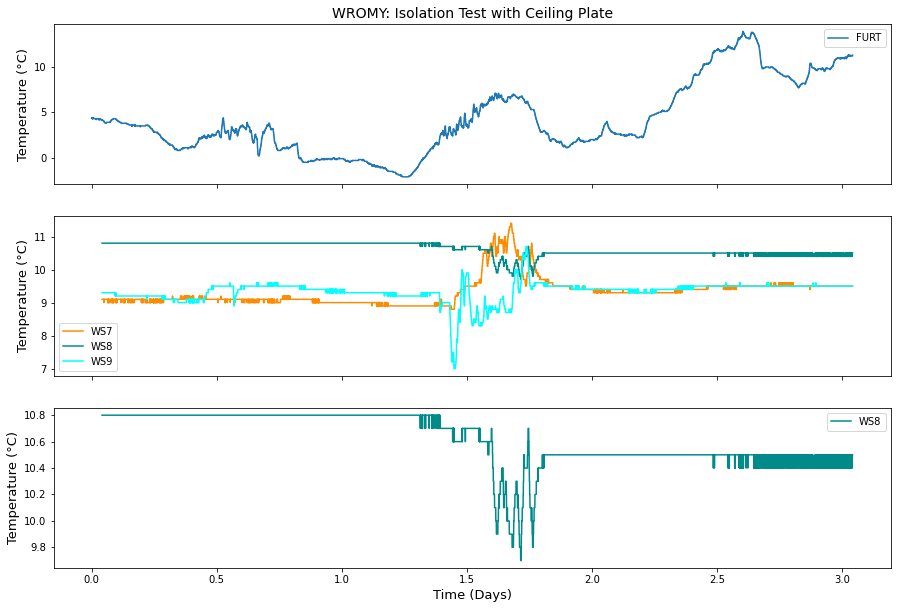

In [59]:
def __makeplot():
    
    N = 3
    font = 13

    fig, ax = plt.subplots(N, 1, figsize=(15,10), sharex=True)

    ref_time = config['tbeg']
    t_scale = 86400
    
    ax[0].plot(furt.select(channel="*T")[0].times(reftime=ref_time)/t_scale, 
               furt.select(channel="*T")[0].data, label="FURT")

    ax[1].plot(ws7.select(channel="*T")[0].times(reftime=ref_time)/t_scale,
               ws7.select(channel="*T")[0].data, c=config['colors']['WS7'], label="WS7")
    ax[1].plot(ws8.select(channel="*T")[0].times(reftime=ref_time)/t_scale, 
               ws8.select(channel="*T")[0].data, c=config['colors']['WS8'], label="WS8")
    ax[1].plot(ws9.select(channel="*T")[0].times(reftime=ref_time)/t_scale, 
               ws9.select(channel="*T")[0].data, c=config['colors']['WS9'], label="WS9")
    
    ax[2].plot(ws8.select(channel="*T")[0].times(reftime=ref_time)/t_scale, 
               ws8.select(channel="*T")[0].data, c=config['colors']['WS8'], label="WS8")
 
    ax[0].set_title("WROMY: Isolation Test with Ceiling Plate", fontsize=font+1)

    ax[0].set_ylabel("Temperature (°C)", fontsize=font)
    ax[1].set_ylabel("Temperature (°C)", fontsize=font)
    ax[2].set_ylabel("Temperature (°C)", fontsize=font)
    ax[2].set_xlabel("Time (Days)", fontsize=font)

    
    for n in range(N):
        ax[n].legend()
    
    plt.show();
    return fig

fig = __makeplot()

In [ ]:
def __make_plot_one_station(data, station, config):

    df = data.get(station)
        
    timeaxis, ticks, ticklabels, text = __get_timeaxis(dates=df.iloc[:,1], 
                                                       times=df.iloc[:,2], 
                                                       unit="date", 
                                                       unitmode="relative",
                                                      )
    
    N = 3
    font = 13

    fig, axes = plt.subplots(N,1, figsize=[15,10], sharex=True)

    for i in range(N):
        ydata = df.iloc[:,i+3]
        
#         axes[i].scatter(timeaxis, df.iloc[:,i+3], s=1, color='grey',lw=3, zorder=2)
        axes[i].plot(timeaxis, ydata, color=config['colors'][station], label=station, lw=1.5, zorder=2)
#         axes[i].fill_between(timeaxis, ydata-0.05, ydata+0.05, color='gray', alpha=0.4)     

    
        axes[i].grid(ls="--",color='grey', zorder=0)
        axes[i].legend(loc="upper right")
        
        if i == 0:
            axes[i].set_ylabel("Temperature (°C)",fontsize=font)
        elif i == 1:
            axes[i].set_ylabel("Air Pressure (hPa)",fontsize=font)
        elif i == 2:
            axes[i].set_ylabel("rel. Humidity (%)",fontsize=font)
            axes[i].set_xlim(timeaxis[0], timeaxis[-1])


        axes[N-1].set_xticklabels(ticklabels)
        axes[N-1].set_xticks(ticks)
        axes[N-1].set_xlabel(text, fontsize=font)

    plt.show();
    return fig

# __make_plot_one_station(data, 'WS1', config);

In [ ]:
def __make_plot_all_stations(data, config):

    N = 3
    font = 13
    datasize = 0
    
    fig, axes = plt.subplots(N,1, figsize=[15,10], sharex=True)
    
    plt.subplots_adjust(hspace=0.05)
    
    max_val, min_val = np.zeros(N)*np.nan, np.zeros(N)*np.nan

    for station in data.keys():
        
        df = data.get(station)

        for u in range(3):
            maximum = df.iloc[:,u+3].dropna().max()
            minimum = df.iloc[:,u+3].dropna().min()
            if maximum > max_val[u] or np.isnan(max_val[u]):
                max_val[u] = maximum
            if minimum < min_val[u] or np.isnan(min_val[u]):
                min_val[u] = minimum
            
        timeaxis, ticks, ticklabels, text = __get_timeaxis(dates=df.iloc[:,1], 
                                                           times=df.iloc[:,2], 
                                                           unit="days", 
                                                           unitmode="relative",
                                                          )
        print(timeaxis)
        ## select ticks and ticklabels for longest data series
        if df.shape[0] > datasize:
            datasize = df.shape[0]
            xticks = ticks
            xlabels = ticklabels
            timeaxis_min, timeaxis_max = timeaxis[0], timeaxis[-1]
        
        ## plot data and adjust axes automatically
        for i in range(N):
#             axes[i].scatter(timeaxis, df.iloc[:,i+3], s=1, color='grey',lw=3, zorder=2)
            axes[i].plot(timeaxis, df.iloc[:,i+3].rolling(300).mean(), color=config['colors'][station], lw=1.5, zorder=2, label=station)
#             axes[i].plot(timeaxis, df.iloc[:,i+3], color=config['colors'][station], lw=1.5, zorder=2, label=station)
#             axes[i].fill_between(timeaxis, df.iloc[:,i+3]-0.05, df.iloc[:,i+3]+0.05, color='gray', alpha=0.2)     

            axes[i].grid(ls="--",color='grey', zorder=0)
            
            if i == 0:
                axes[i].set_ylabel("Temperature (°C)",fontsize=font)
            elif i == 1:
                axes[i].set_ylabel("Air Pressure (hPa)",fontsize=font)
            elif i == 2:
                axes[i].set_ylabel("rel. Humidity (%)",fontsize=font)
                axes[i].set_xlim(timeaxis_min, timeaxis_max)

            axes[N-1].set_xticklabels(xlabels)
            axes[N-1].set_xticks(xticks)
            axes[N-1].set_xlabel(text, fontsize=font)
            axes[N-1].legend(loc='upper center', ncol=7, bbox_to_anchor=(0.5, -0.2), fancybox=True)
        
        ## adjust y-limits
#     for k in range(N):
#         axes[k].set_ylim(min_val[k]-0.005*min_val[k], max_val[k]+0.005*min_val[k])
        
    plt.show();
    return fig

#__make_plot_all_stations(data, config);

In [ ]:
def __make_plot_all_stations_and_furt(data, furt, config, events=None):
    
    N = 3
    font = 13
    datasize = 0
    
    fig, axes = plt.subplots(N,1, figsize=[15,10], sharex=True)
    
    plt.subplots_adjust(hspace=0.1)
    
    max_val, min_val = np.zeros(N)*np.nan, np.zeros(N)*np.nan
    
    timeaxis_furt, ticks_furt, ticklabels_furt, text_furt = __get_timeaxis(
                                                                           dates=furt.iloc[:,0], 
                                                                           times=furt.iloc[:,1], 
                                                                           unit='date', 
                                                                           unitmode="absolute",
                                                                           dateformat="ddmmyy",
                                                                          )    
    for station in data.keys():
        
        df = data.get(station)

        for u in range(3):
            maximum = df.iloc[:,u+3].dropna().max()
            minimum = df.iloc[:,u+3].dropna().min()
            if maximum > max_val[u] or np.isnan(max_val[u]):
                max_val[u] = maximum
            if minimum < min_val[u] or np.isnan(min_val[u]):
                min_val[u] = minimum
            
        timeaxis, ticks, ticklabels, text = __get_timeaxis(dates=df.iloc[:,1], 
                                                           times=df.iloc[:,2], 
                                                           unit='date', 
                                                           unitmode="absolute",
                                                           dateformat="yyyymmdd",
                                                          )


        ## select ticks and ticklabels for longest data series
        if df.shape[0] > datasize:
            datasize = df.shape[0]
            xticks = ticks
            xlabels = ticklabels
            timeaxis_min, timeaxis_max = timeaxis[0], timeaxis[-1]
        
#         print(xticks, xlabels, ticklabels)
#         print(len(timeaxis_furt), timeaxis_furt[0], timeaxis_furt[-1], len(timeaxis), timeaxis[0], timeaxis[-1])
    
        ## plot data and adjust axes automatically
        for i in range(N):
            
#             axes[i].scatter(timeaxis, df.iloc[:,i+3], s=1, color='grey',lw=3, zorder=2)
#             axes[i].plot(timeaxis, df.iloc[:,i+3], color=config['colors'][station], lw=1.5, zorder=2, label=station)
            axes[i].plot(timeaxis, df.iloc[:,i+3].rolling(60).mean(), color=config['colors'][station], lw=1.5, zorder=2, label=station)

            if station == list(data.keys())[-1]:
                axes[i].plot(timeaxis_furt, furt.iloc[:,i+2], color='darkgrey', lw=1.5, zorder=1, label="FURT")
       
            axes[i].grid(ls="--",color='grey', zorder=0)
            
            if i == 0:
                axes[i].set_ylabel("Temperature (°C)",fontsize=font)
            elif i == 1:
                axes[i].set_ylabel("Air Pressure (hPa)",fontsize=font)
            elif i == 2:
                axes[i].set_ylabel("rel. Humidity (%)",fontsize=font)
                axes[i].set_xlim(timeaxis_min, timeaxis_max)

#             axes[N-1].set_xticklabels(xlabels[::4], fontsize=font-2)
#             axes[N-1].set_xticks(xticks[::4])
            axes[N-1].set_xticks(xticks)
            axes[N-1].set_xticklabels(xlabels, fontsize=font-2)
            axes[N-1].set_xlabel(text, fontsize=font)
            axes[N-1].legend(loc='upper center', ncol=7+1, bbox_to_anchor=(0.5, -0.2), fancybox=True, fontsize=font-2)

            if events:
                for event in events:
#                     axes[i].axvline(event, color='r', zorder=0, ls="-.")
                    axes[i].axvspan(event[0], event[1], color="lightgrey", alpha=0.4, zorder=1)
          
        ## adjust y-limits
#     for k in range(N):
#         axes[k].set_ylim(min_val[k]-0.005*min_val[k], max_val[k]+0.005*min_val[k])
        
    plt.show();
    return fig

#__make_plot_all_stations_and_furt(data, furt, config, events=None);